<a href="https://colab.research.google.com/github/LugoBlogger/MLCC-Assignment-05/blob/arul%2Fmodelling/medical_cost_forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

* motivation why we choose that dataset.
* what we want to predict.
* is it interesting enough or not.

In [3]:
# Use seaborn for pairplot
!pip install -q seaborn

# Use some functions from tensorflow_docs
!pip install -q git+https://github.com/tensorflow/docs

In [0]:
# Use tensorflow 2
%tensorflow_version 2.x

In [0]:
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [6]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.2.0-rc1


In [0]:
### this library is for callback functions
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

# Medical Cost Personal Datasets

## Retrieve the dataset

Manage the dataset into pandas' DataFrame.

In [8]:
dataset = pd.read_csv("https://raw.githubusercontent.com/LugoBlogger/MLCC-Assignment-05/master/datasets/insurance.csv", header=0)
dataset

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


## Clean the data

Checking the dataset whether is clean or not.

In [9]:
dataset.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

Convert categorical columns into numeric with the following convention:

* `sex`: male = 1, female = 2,

* `smoker`: yes = 1, no = 0,

* `region`: northeast = $\displaystyle\frac{\pi}{4}$, northwest = $\displaystyle\frac{3\pi}{4}$, southwest = $\displaystyle\frac{5\pi}{4}$, southeast = $\displaystyle\frac{7\pi}{4}$. We use the representation of direction by their angle on unit circle. If we compute the method `.mean`, it will make a sense (where is the region whose citizens are the most recorded).

In [10]:
dataset.loc[dataset['sex'] == 'male', 'sex'] = 1
dataset.loc[dataset['sex'] == 'female', 'sex'] = 2

dataset.loc[dataset['smoker'] == 'yes', 'smoker'] = 1
dataset.loc[dataset['smoker'] == 'no', 'smoker'] = 0

dataset.loc[dataset['region'] == 'northeast', 'region'] = np.pi/4
dataset.loc[dataset['region'] == 'northwest', 'region'] = 3*np.pi/4
dataset.loc[dataset['region'] == 'southwest', 'region'] = 5*np.pi/4
dataset.loc[dataset['region'] == 'southeast', 'region'] = 7*np.pi/4

dataset['region'] = pd.to_numeric(dataset['region'])

dataset

,age,sex,bmi,children,smoker,region,charges
0,19,2,27.900,0,1,3.926991,16884.92400
1,18,1,33.770,1,0,5.497787,1725.55230
2,28,1,33.000,3,0,5.497787,4449.46200
3,33,1,22.705,0,0,2.356194,21984.47061
4,32,1,28.880,0,0,2.356194,3866.85520
...,...,...,...,...,...,...,...
1333,50,1,30.970,3,0,2.356194,10600.54830
1334,18,2,31.920,0,0,0.785398,2205.98080
1335,18,2,36.850,0,0,5.497787,1629.83350
1336,21,2,25.800,0,0,3.926991,2007.94500


In [11]:
target = dataset['charges']
features = dataset.drop(columns='charges')

features.head()

,age,sex,bmi,children,smoker,region
0,19,2,27.900,0,1,3.926991
1,18,1,33.770,1,0,5.497787
2,28,1,33.000,3,0,5.497787
3,33,1,22.705,0,0,2.356194
4,32,1,28.880,0,0,2.356194


## Split the data into a training set and a test set.

In [0]:
class SortedStratifiedKFold:
    
    """
    This is a class for split data into a few groups, which is each group has same distribution.
    Usually this method regarded as Stratified K Fold Cross Validation. But I create another one
    for continuous data at target's dataset with Sorted Stratified K Fold method. This method inspired
    by article (https://scottclowe.com/2016-03-19-stratified-regression-partitions/).
    
    This method is useful to make sure validation and test performance gives depicts 
    the expected performance of the model with less bias and variance.
    """
    
    def __init__(self, n_splits):
        self._n_splits = n_splits
    
    def split(self, X, y):
        x = X.copy()
        
        # sorted target values
        self._sorted_idx = y.sort_values().index
        
        self._groups = [list() for _ in range(self._n_splits)]
        it = int(np.ceil(x.shape[0] / self._n_splits))
        
        for i in range(it):
            c = i * self._n_splits
            
            if (len(y) % self._n_splits != 0) and i==(it-1):
                rand_idx = np.random.permutation(range(len(y) % self._n_splits)) + c
                
                for j in range(len(rand_idx)):
                    self._groups[j].append(self._sorted_idx[rand_idx[j]])
                
            else:
                rand_idx = np.random.permutation(range(self._n_splits)) + c
                
                for j in range(self._n_splits):
                    self._groups[j].append(self._sorted_idx[rand_idx[j]])
                    
                  
        return [(x.iloc[list(set(y.index) - set(idx))], y.iloc[list(set(y.index) - set(idx))], 
                                 x.iloc[idx], y.iloc[idx]) for idx in self._groups]

we divided the dataset into 5 groups to get 20% of data for test set

Text(0.5, 1.0, 'Test data distribution')

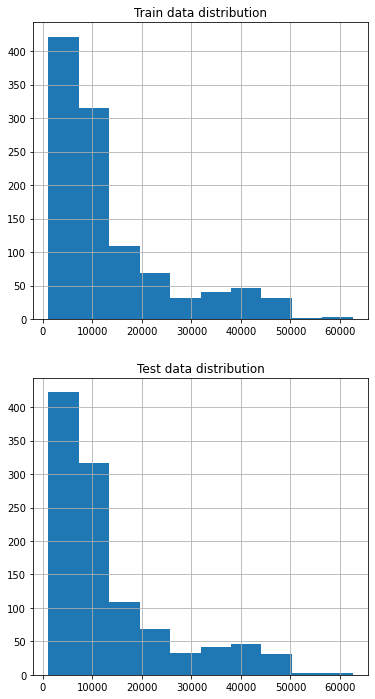

In [13]:

ssfk = SortedStratifiedKFold(n_splits=5)

train_test_split = ssfk.split(features, target)
train_features, train_target, test_features, test_target = train_test_split[0]

plt.figure(figsize=(6,12))
plt.subplot(211)
train_target.hist().set_title('Train data distribution')
plt.subplot(212)
train_target.hist().set_title('Test data distribution')

## Inspect the data

We look at the joint distribution of a few pairs of columns from the training set. The diagonal elements represent kerned density estimation (kde) for univariate variables for given columns. We include all the columns to inspect which variable has a correlation to another variable

In [14]:
train_dataset = train_features.copy()
train_dataset[train_target.name] = train_target.copy()
train_dataset.head()

,age,sex,bmi,children,smoker,region,charges
0,19,2,27.90,0,1,3.926991,16884.9240
1,18,1,33.77,1,0,5.497787,1725.5523
2,28,1,33.00,3,0,5.497787,4449.4620
5,31,2,25.74,0,0,5.497787,3756.6216
6,46,2,33.44,1,0,5.497787,8240.5896


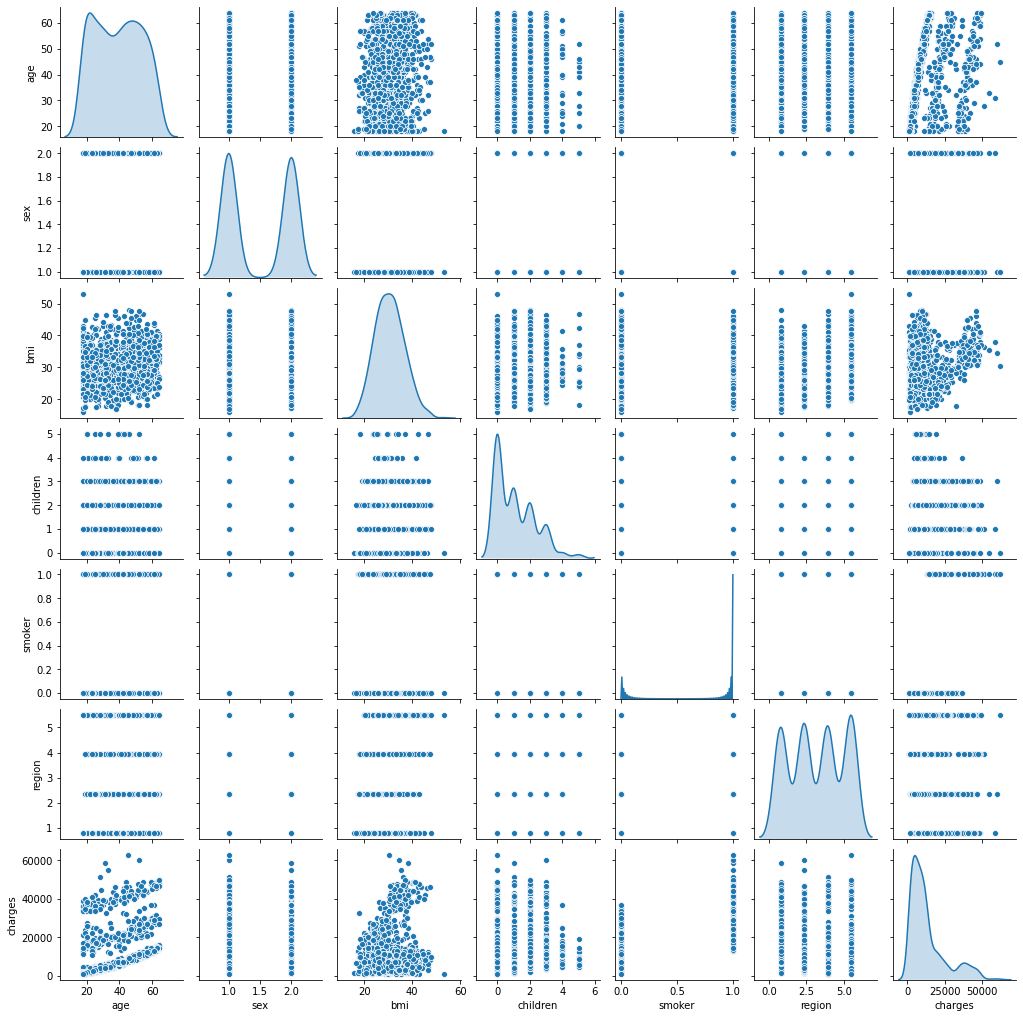

In [15]:
sns.pairplot(train_dataset[['age', 'sex', 'bmi', 'children', 'smoker', 
                            'region', 'charges']], 
             diag_kind='kde', height=2);

If we look at the above table, we see that BMI and charges have an intriguing pattern.

We also inspect at their statistical description:

In [16]:
train_stats = train_dataset.describe()
train_stats.pop('charges')

# for pretty output
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
age,1070.0,39.142056,14.047241,18.000000,26.000000,39.000000,51.000000,64.000000
sex,1070.0,1.491589,0.500163,1.000000,1.000000,1.000000,2.000000,2.000000
bmi,1070.0,30.737290,6.027030,15.960000,26.400000,30.497500,34.693750,53.130000
children,1070.0,1.103738,1.204717,0.000000,0.000000,1.000000,2.000000,5.000000
smoker,1070.0,0.209346,0.407032,0.000000,0.000000,0.000000,0.000000,1.000000
region,1070.0,3.198846,1.767881,0.785398,2.356194,3.926991,5.497787,5.497787


### Normalize the data

In [0]:
def normalize(x_val):
    return (x_val - train_stats['mean']) / train_stats['std']

normed_train_features = normalize(train_features)
normed_test_features = normalize(test_features)

In [18]:
normed_train_features.head()

,age,sex,bmi,children,smoker,region
0,-1.433880,1.016491,-0.470761,-0.916181,1.942487,0.411874
1,-1.505068,-0.982857,0.503185,-0.086110,-0.514323,1.300394
2,-0.793185,-0.982857,0.375427,1.574031,-0.514323,1.300394
5,-0.579620,1.016491,-0.829146,-0.916181,-0.514323,1.300394
6,0.488206,1.016491,0.448432,-0.086110,-0.514323,1.300394


## Modelling Data


### Construct the model
In this model we use the multilayer perceptron model with two densely connected hidden layars (`layer.Dense(64)`), and an output layer that returns a single continuous value (`layer.Dense(1)`).

In [0]:
def multilayer_perceptron(num_features, learning_rate, optimizers, regularizer_rate=0, dropout_rate=0):
    
    num_perceptron=64
    
    # set optimizers
    if optimizers=='adam':
        opt = tf.keras.optimizers.Adam(lr=learning_rate)
    elif optimizers=='rmsprop':
        opt = tf.keras.optimizers.RMSprop(lr=learning_rate)
    elif optimizers=='sgd':
        opt = tf.keras.optimizers.SGD(lr=learning_rate)
    
    
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(units=num_perceptron, activation='relu', 
                                    kernel_regularizer=tf.keras.regularizers.l2(regularizer_rate), 
                                    input_shape=(num_features,)))
    model.add(tf.keras.layers.Dropout(dropout_rate))
    model.add(tf.keras.layers.Dense(units=num_perceptron, 
                                    kernel_regularizer=tf.keras.regularizers.l2(regularizer_rate), 
                                    activation='relu'))
    model.add(tf.keras.layers.Dropout(dropout_rate))
    model.add(tf.keras.layers.Dense(units=1, activation='relu'))
    
        
    model.compile(optimizer=opt, loss='mae', 
                  metrics=['mae', 'mse'])
    
    return model
    
    
def train_model(model, features, target, epoch):
    
    history = model.fit(x=features, y=target, epochs=epoch, verbose=0)
    
    hist = pd.DataFrame(history.history)
    
    return model, hist

## Hypertuning Parameter

### Optimizer with different learning rate

In [0]:
normed_train_features = normed_train_features.reset_index()[features.columns]
train_target = train_target.reset_index()['charges']

ssfk = SortedStratifiedKFold(n_splits=4)
train_val_split = ssfk.split(normed_train_features, train_target)


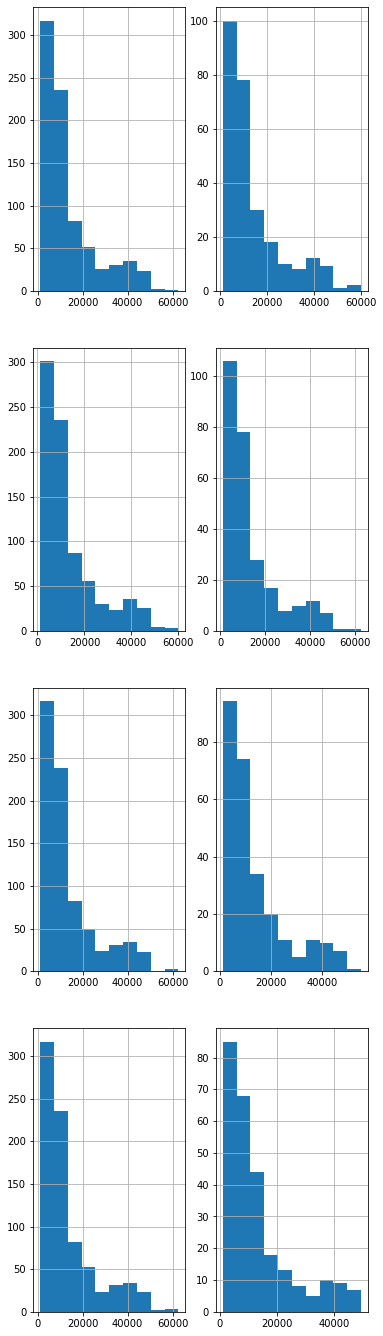

In [21]:

i = 0
plt.figure(figsize=(6, 24))
for train_feature, train_target, test_feature, test_target in train_val_split:
    i += 1
    plt.subplot(4, 2, i)
    train_target.hist()
    
    i += 1
    plt.subplot(4, 2, i)
    test_target.hist()

In [22]:
train_target.shape

(803,)

In [0]:
learning_rates_list = [.001, .0025, .005, .0075, .01, .025, .05, .075, .1]
result_report = pd.DataFrame({'Learning Rate': learning_rates_list})
result_report

,Learning Rate
0,0.0010
1,0.0025
2,0.0050
3,0.0075
4,0.0100
5,0.0250
6,0.0500
7,0.0750
8,0.1000


In [0]:
i = 0
for train_features, train_target, validation_features, validation_target in train_val_split:

  adam_mae, rmsprop_mae, sgd_mae = [], [], []
  i += 1
  print('Adam training process...')
  for lr in learning_rates_list:
    mlp = multilayer_perceptron(train_features.shape[1], lr, 'adam')
    model, history = train_model(mlp, train_features, train_target, 4000)
    loss, mae, mse = model.evaluate(validation_features, validation_target, verbose=0)
    adam_mae.append(mae)

  print('RMSprop training process...')
  for lr in learning_rates_list:
    mlp = multilayer_perceptron(train_features.shape[1], lr, 'rmsprop')
    model, history = train_model(mlp, train_features, train_target, 4000)
    loss, mae, mse = model.evaluate(validation_features, validation_target, verbose=0)
    rmsprop_mae.append(mae)

  print('SGD training process...')
  for lr in learning_rates_list:
    mlp = multilayer_perceptron(train_features.shape[1], lr, 'sgd')
    model, history = train_model(mlp, train_features, train_target, 4000)
    loss, mae, mse = model.evaluate(validation_features, validation_target, verbose=0)
    sgd_mae.append(mae)

  result_report['Adam-'+str(i)] = adam_mae
  result_report['RMSprop-'+str(i)] = rmsprop_mae
  result_report['SGD-'+str(i)] = sgd_mae

Adam training process...
RMSprop training process...
SGD training process...
Adam training process...
RMSprop training process...
SGD training process...
Adam training process...
RMSprop training process...
SGD training process...
Adam training process...
RMSprop training process...
SGD training process...


In [0]:
result_report

,Learning Rate,Adam-1,RMSprop-1,SGD-1,Adam-2,RMSprop-2,SGD-2,Adam-3,RMSprop-3,SGD-3,Adam-4,RMSprop-4,SGD-4
0,0.0010,1458.143188,1520.175781,1883.308594,1528.725952,1558.559570,2371.051514,1637.156372,1663.007080,2049.893311,1127.586548,1097.733398,1460.407349
1,0.0025,1458.064331,1500.148560,2727.994873,1519.334961,1587.777344,2027.377808,1643.432251,1747.403198,2148.179443,1103.326172,1123.664307,1684.702026
2,0.0050,1483.021973,1507.040527,2769.117432,1591.852173,1686.428223,4432.504395,1673.974609,1819.202637,2642.294678,1079.315308,1078.089478,2323.706543
3,0.0075,1604.294922,1670.871460,2718.351074,1561.667358,1619.615601,3226.201416,1647.823486,1710.166138,3429.767822,1187.486816,1354.322998,2506.330322
4,0.0100,1469.069458,1583.524902,2497.881592,1719.432617,1777.004639,7135.844238,1694.716919,1866.908691,3505.865967,1418.779785,1345.738159,3440.203857
5,0.0250,1619.139282,1905.066650,7607.291992,1928.603271,2213.759277,11310.122070,2191.119873,2268.777832,12390.261719,2358.056152,2103.949219,7858.142090
6,0.0500,1943.076294,2190.281006,13354.930664,1892.720093,2436.568359,9843.088867,1731.343994,2176.463379,13145.859375,1301.197754,1622.472778,7352.003418
7,0.0750,1683.234741,1779.628662,9244.664062,1956.500977,2384.955811,9440.741211,1712.396362,2473.889160,9047.465820,1248.693604,2369.197754,9256.005859
8,0.1000,1765.589111,1885.554321,8899.640625,1795.631348,2343.979004,10785.481445,1674.635254,1982.307373,8696.228516,1219.947632,2062.276855,8765.383789


In [0]:
result_report['Adam-Avg'] = (result_report['Adam-1'] + result_report['Adam-2'] + result_report['Adam-3'] + result_report['Adam-4']) / 4
result_report['RMSprop-Avg'] = (result_report['RMSprop-1'] + result_report['RMSprop-2'] + result_report['RMSprop-3'] + result_report['RMSprop-4']) / 4
result_report['SGD-Avg'] = (result_report['SGD-1'] + result_report['SGD-2'] + result_report['SGD-3'] + result_report['SGD-4']) / 4
result_report

,Learning Rate,Adam-1,RMSprop-1,SGD-1,Adam-2,RMSprop-2,SGD-2,Adam-3,RMSprop-3,SGD-3,Adam-4,RMSprop-4,SGD-4,Adam-Avg,RMSprop-Avg,SGD-Avg
0,0.0010,1458.143188,1520.175781,1883.308594,1528.725952,1558.559570,2371.051514,1637.156372,1663.007080,2049.893311,1127.586548,1097.733398,1460.407349,1437.903015,1459.868958,1941.165192
1,0.0025,1458.064331,1500.148560,2727.994873,1519.334961,1587.777344,2027.377808,1643.432251,1747.403198,2148.179443,1103.326172,1123.664307,1684.702026,1431.039429,1489.748352,2147.063538
2,0.0050,1483.021973,1507.040527,2769.117432,1591.852173,1686.428223,4432.504395,1673.974609,1819.202637,2642.294678,1079.315308,1078.089478,2323.706543,1457.041016,1522.690216,3041.905762
3,0.0075,1604.294922,1670.871460,2718.351074,1561.667358,1619.615601,3226.201416,1647.823486,1710.166138,3429.767822,1187.486816,1354.322998,2506.330322,1500.318146,1588.744049,2970.162659
4,0.0100,1469.069458,1583.524902,2497.881592,1719.432617,1777.004639,7135.844238,1694.716919,1866.908691,3505.865967,1418.779785,1345.738159,3440.203857,1575.499695,1643.294098,4144.948914
5,0.0250,1619.139282,1905.066650,7607.291992,1928.603271,2213.759277,11310.122070,2191.119873,2268.777832,12390.261719,2358.056152,2103.949219,7858.142090,2024.229645,2122.888245,9791.454468
6,0.0500,1943.076294,2190.281006,13354.930664,1892.720093,2436.568359,9843.088867,1731.343994,2176.463379,13145.859375,1301.197754,1622.472778,7352.003418,1717.084534,2106.446381,10923.970581
7,0.0750,1683.234741,1779.628662,9244.664062,1956.500977,2384.955811,9440.741211,1712.396362,2473.889160,9047.465820,1248.693604,2369.197754,9256.005859,1650.206421,2251.917847,9247.219238
8,0.1000,1765.589111,1885.554321,8899.640625,1795.631348,2343.979004,10785.481445,1674.635254,1982.307373,8696.228516,1219.947632,2062.276855,8765.383789,1613.950836,2068.529388,9286.683594


In [0]:
result_report.to_excel('hyper tuning parameter learningrate and optimizer.xlsx', index=False)
print('Saved process done.')

Saved process done.


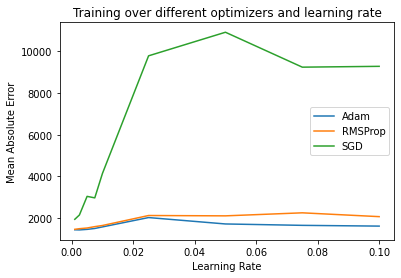

In [0]:
plt.plot(result_report['Learning Rate'], result_report['Adam-Avg'], label='Adam')
plt.plot(result_report['Learning Rate'], result_report['RMSprop-Avg'], label='RMSProp')
plt.plot(result_report['Learning Rate'], result_report['SGD-Avg'], label='SGD')

plt.title('Training over different optimizers and learning rate')
plt.xlabel('Learning Rate')
plt.ylabel('Mean Absolute Error')
plt.legend()

Small learning rate gives better result.

Best parameter -> Adam optimizer with learning rate 0.025

### Regularization & Drop Out

<b>Regularizers</b> allow you to apply penalties on layer parameters or layer activity during optimization. These penalties are summed into the loss function that the network optimizes.

<b>Dropout</b> is one of the most effective and most commonly used regularization techniques for neural networks. The intuitive explanation for dropout is that because individual nodes in the network cannot rely on the output of the others, each node must output features that are useful on their own.

We can combined both of them to avoid overfitting.


In [0]:
regularizer_rates = [0, .001, .01, .1]
dropout_rates = [0, .2, .35, .5]

In [25]:
i = 1
drp_log, reg_log, mae_log ,mse_log = [], [], [], []

for train_features, train_target, validation_features, validation_target in train_val_split:
  
  for dropout_rate in dropout_rates:
    print('.......')
    for regularizer_rate in regularizer_rates:
       mlp = multilayer_perceptron(train_features.shape[1], .025, 'adam', regularizer_rate, dropout_rate)
       model, history = train_model(mlp, train_features, train_target, 4000)
       loss, mae, mse = model.evaluate(validation_features, validation_target, verbose=0)
       drp_log.append(dropout_rate)
       reg_log.append(regularizer_rate)
       mae_log.append(mae)
       mse_log.append(mse)

  print('Done for group-',str(i))
  i += 1


.......
.......
.......
.......
Done for group- 1
.......
.......
.......
.......
Done for group- 2
.......
.......
.......
.......
Done for group- 3
.......
.......
.......
.......
Done for group- 4


In [36]:
grp = ["Group-1"]*16 + ["Group-2"]*16 + ["Group-3"]*16 + ["Group-4"]*16
len(grp)

64

In [37]:
drp_reg_result = pd.DataFrame({"Group": grp, "Drop-out rate": drp_log, "Regularizer rate": reg_log,
                               "Mean Absolute Error": mae_log, "Mean Squared Error": mse_log})
drp_reg_result

,Group,Drop-out rate,Regularizer rate,Mean Absolute Error,Mean Squared Error
0,Group-1,0.00,0.000,1704.239746,25148408.0
1,Group-1,0.00,0.001,1574.438232,25726460.0
2,Group-1,0.00,0.010,1532.303589,25289728.0
3,Group-1,0.00,0.100,1521.789795,24813542.0
4,Group-1,0.20,0.000,2127.277100,28151118.0
...,...,...,...,...,...
59,Group-4,0.35,0.100,2295.309814,24410332.0
60,Group-4,0.50,0.000,2114.799072,23403926.0
61,Group-4,0.50,0.001,1960.350220,22033832.0
62,Group-4,0.50,0.010,2018.504395,21881678.0


In [38]:
drp_reg_result.to_excel('hyper tuning parameter regularization and drop-out.xlsx', index=False)
print('Saved process done.')

Saved process done.


In [46]:
grp_result = drp_reg_result.groupby(['Drop-out rate', 'Regularizer rate'])[['Mean Absolute Error', 'Mean Squared Error']].mean()
grp_result

Mean Absolute Error  Mean Squared Error
Drop-out rate Regularizer rate                                         
0.00          0.000                     1694.574493          31464296.0
              0.001                     1566.558960          22612818.0
              0.010                     1539.876160          22667506.0
              0.100                     1561.972656          21718349.0
0.20          0.000                     1934.855377          23710436.5
              0.001                     1826.466309          22503157.5
              0.010                     1922.687927          22964797.5
              0.100                     2279.097046          26272783.0
0.35          0.000                     2028.263489          24560441.5
              0.001                     2085.476593          25030113.0
              0.010                     2243.391571          25471856.5
              0.100                     2197.897217          25249228.0
0.50          0.000                     2115.166199          25045874.5
              0.001                     2177.113068          25701427.5
              0.010                     2135.597351          25074145.0
              0.100                     2209.479431          24979922.0

Refer to previous experiment, the better result comes with drop-out rate = 0 and regularizer rate = 0.01 (mae), 0.1 (mse)

### Evaluate with test set

After work on hyper tuning parameter, we can apply the best parameter to test set. And see whether a overfitting issue or not

In [0]:
mae_log ,mse_log = [], []

for train_features, train_target, validation_features, validation_target in train_val_split:

  mlp = multilayer_perceptron(train_features.shape[1], .025, 'adam', 0.01, 0)
  model, history = train_model(mlp, train_features, train_target, 4000)
  loss, mae, mse = model.evaluate(validation_features, validation_target, verbose=0)
  mae_log.append(mae)
  mse_log.append(mse)

In [68]:
grp_log = ['Group-'+str(i) for i in range(1, 5)]
log = pd.DataFrame({"Group": grp_log, "Mean Absolute Error": mae_log, "Mean Squared Error": mse_log})
print('Test result with validation set that obtained from train-validation-test split using Sorted Stratified K Fold Cross Validation')
log

Test result with validation set that obtained from train-validation-test split using Sorted Stratified K Fold Cross Validation


,Group,Mean Absolute Error,Mean Squared Error
0,Group-1,1510.414185,24642996.0
1,Group-2,1484.146973,24508814.0
2,Group-3,1540.083862,20895390.0
3,Group-4,1416.736450,20536362.0


In [69]:

print("Minimum MAE =  ",log["Mean Absolute Error"].min())
print("Maximum MAE =  ",log["Mean Absolute Error"].max())
print("Average MAE =  ",log["Mean Absolute Error"].mean())

Minimum MAE =   1416.7364501953125
Maximum MAE =   1540.0838623046875
Average MAE =   1487.8453674316406


Right now, we know that our model can get result with 'Mean Absolute Error' between 1416,74 and 1540,08. Now lets check with test set.

> If you run the cell many times you can get different result. But the interval of MAE will not be much different

In [71]:
test_target = target[normed_test_features.index]
loss, mae, mse = model.evaluate(normed_test_features, test_target)

print("MAE for testing set =  {:5.2f} (charges)".format(mae))

9/9 [==============================] - 0s 1ms/step - loss: 1790.9459 - mae: 1639.3760 - mse: 22526778.0000
MAE for testing set =  1639.38 (charges)


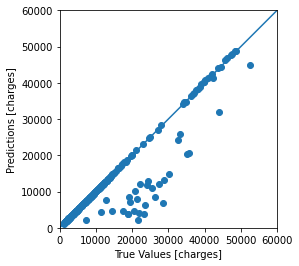

In [76]:
test_predictions = model.predict(normed_test_features).flatten()

a = plt.axes(aspect='equal')

plt.scatter(test_target, test_predictions)

plt.xlabel('True Values [charges]')
plt.ylabel('Predictions [charges]')
lims = [0, 6e4]
plt.xlim(lims)
plt.ylim(lims)

_ = plt.plot(lims, lims)

For this testing we get MAE of 1639,38
If we compare with result that we obtained from validation set, our model can predict data with MAE 1487,84. We get difference of 151,54 from model validation. That is good result <b>(not overfitting)</b>.